# PSA demodulation Numpy vs OpenCV
aqui comparamos los tiempos de un demodulador PSA implementado numpy o openCV

## importamos y creamos entorno

In [1]:

import numpy as np
import cv2
from matplotlib import pyplot as plt
import timeit

## Funciones aux

In [70]:
def calculateTestPhasor(z_size=(512, 511), T_period=(30, 30),
                        amplitude=100, bkg = 128, phase_steps = np.zeros(1), 
                        sigma_factor=(0.3, 0.3)):
    # setup meshgrid and phasor
    NR, NC = z_size
    x = np.arange(0, NC)
    x = x - 0.5 * NC
    y = np.arange(0, NR)
    y = y - 0.5 * NR

    X, Y = np.meshgrid(x, y)

    # fringe period in Px
    Tx, Ty = T_period

    # phase, background and modulation
    phi = 2 * np.pi * (X / Tx + Y / Ty)
    factor_x, factor_y = sigma_factor
    sigma_x, sigma_y = (factor_x * NC, factor_y * NR)  # px
    m = amplitude * np.exp(-X ** 2 / (2 * sigma_x ** 2) - Y ** 2 / (2 * sigma_y ** 2))
    z = m * (np.cos(phi) + 1j * np.sin(phi))
    
    nIgrams=phase_steps.size
    gList= np.zeros((nIgrams, NR, NC))
    for n in range(nIgrams):
        gList[n] = bkg + m * np.cos(phi+phase_steps[n])
        
    return z, gList, m

## Generamos datos

In [71]:
zSize=(1800, 3*1801) # size in px
T=(1000/5, 0.001) # period in px
N=8
w0=2*np.pi/N
equispacedPhaseSteps=w0*np.arange(0, N)
z, gList, m = calculateTestPhasor(z_size=zSize, T_period=T, phase_steps=equispacedPhaseSteps)

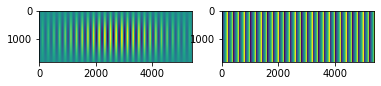

In [72]:
plt.subplot(121);plt.imshow(gList[0]-gList[2]) # expect true color
plt.subplot(122);plt.imshow(np.angle(z)) 
plt.show()

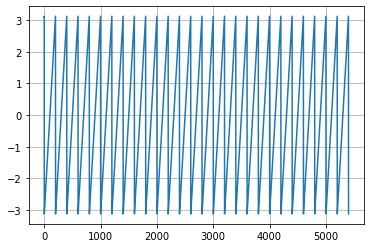

In [73]:
plt.plot(np.angle(z[400, :]))
plt.grid()
plt.show()

## demodulacion numpy

In [74]:
#hPSA4LS=np.array([1, 1j, -1, -1)
hPSA4LS=np.exp(1j*equispacedPhaseSteps)

In [75]:
print(hPSA4LS)

[ 1.00000000e+00+0.00000000e+00j  7.07106781e-01+7.07106781e-01j
  6.12323400e-17+1.00000000e+00j -7.07106781e-01+7.07106781e-01j
 -1.00000000e+00+1.22464680e-16j -7.07106781e-01-7.07106781e-01j
 -1.83697020e-16-1.00000000e+00j  7.07106781e-01-7.07106781e-01j]


In [76]:
def demodulateNumpy(gList, hPSA):
    nIgrams= hPSA4LS.size
    h=hPSA.reshape(nIgrams, 1, 1)
    z=np.sum(h * gList, axis=0)  
    return z
    

In [77]:
zDNumpy=demodulateNumpy(gList, hPSA4LS)

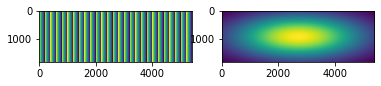

In [78]:
plt.subplot(121);plt.imshow(np.angle(zDNumpy)) # expect true color
plt.subplot(122);plt.imshow(np.abs(zDNumpy))
plt.show()

In [79]:
loop=100
result = timeit.timeit(lambda: demodulateNumpy(gList, hPSA4LS), number=loop)
print(result / loop)

0.8450267140000005


## Demodulacion openCV

In [63]:
def demodulateOpenCV(gList, hPSA):
    nIgrams, NR, NC = gList.shape
    s=np.zeros((NR, NC))
    c=np.zeros((NR, NC))
    n=0
    for n in range(nIgrams):
        c=cv2.scaleAdd(gList[n], np.real(hPSA[n]), c)
        s=cv2.scaleAdd(gList[n], np.imag(hPSA[n]), s)
        n=n+1
    return c + 1j*s
    

In [64]:
zDCV=demodulateOpenCV(gList, hPSA4LS)

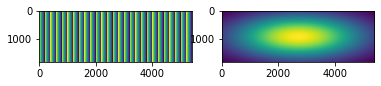

In [65]:
plt.subplot(121);plt.imshow(np.angle(zDCV)) # expect true color
plt.subplot(122);plt.imshow(np.abs(zDCV))
plt.show()

In [66]:
loop=100
result = timeit.timeit(lambda: demodulateOpenCV(gList, hPSA4LS), number=loop)
print(result / loop)

0.4706650879999995


In [67]:
%whos

Variable               Type        Data/Info
--------------------------------------------
T                      tuple       n=2
calculateTestPhasor    function    <function calculateTestPh<...>or at 0x0000021591DBA1F0>
cv2                    module      <module 'cv2' from 'c:\\u<...>kages\\cv2\\__init__.py'>
demodulateNumpy        function    <function demodulateNumpy at 0x0000021591EC0DC0>
demodulateOpenCV       function    <function demodulateOpenCV at 0x00000215915768B0>
equispacedPhaseSteps   ndarray     4: 4 elems, type `float64`, 32 bytes
gList                  ndarray     4x1800x5403: 38901600 elems, type `float64`, 311212800 bytes (296.795654296875 Mb)
hPSA4LS                ndarray     4: 4 elems, type `complex128`, 64 bytes
loop                   int         100
m                      ndarray     1800x5403: 9725400 elems, type `float64`, 77803200 bytes (74.19891357421875 Mb)
np                     module      <module 'numpy' from 'c:\<...>ges\\numpy\\__init__.py'>
plt       